# Part2 機械学習の進め方 Chap.5 特徴量エンジニアリング

## 5.1 特徴量エンジニアリングの進め方

- ベースラインの作成
  - ライブラリのインポート
  - ファイルの読み込み
  - データセット作成
  - モデルの学習・評価の関数定義
  - モデルの学習・評価
- 特徴量エンジニアリング
  - 変数追加・データセット作成
  - モデル学習・評価

In [2]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import os
import pickle
import gc

# オリジナルで追加
from pprint import pprint
from IPython.display import display

# 分布確認
# import pandas_profiling as pdp
# 可視化
import matplotlib.pyplot as plt

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

# モデリング
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [3]:
# ファイルの読み込み
df_train = pd.read_csv("./titanic/train.csv")
display(df_train.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# データセットの作成
x_train, y_train, id_train = df_train[["Pclass", "Fare"]], df_train[["Survived"]], df_train[["PassengerId"]]
print(x_train.shape, y_train.shape, id_train.shape)

(891, 2) (891, 1) (891, 1)


In [6]:
# モデル学習・評価の関数定義
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "num_leaves": 16,
    "n_estimators": 100000,
    "random_state": 123,
    "importance_type": "gain",
    "early_stopping_rounds": 100,
    "verbose": 10,
}

# モデル学習の実行（クロスバリデーション）
def train_cv(
    input_x,
    input_y,
    input_id,
    params,
    n_splits=5,
):
    metrics = list()
    imp = pd.DataFrame()

    # データセット作成
    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(input_x, input_y))
    for nfold in np.arange(n_splits):
        print("-"*20, nfold, "-"*20)
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
        x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print(f"{y_train["Survived"].mean():.3f},  {y_tr["Survived"].mean():.3f},  {y_va["Survived"].mean():.3f}")

        # モデル学習
        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_tr,
            y_tr,
            eval_set=[(x_tr, y_tr), (x_va, y_va)],
        )

        # 精度の評価
        y_tr_pred = model.predict(x_tr)
        y_va_pred = model.predict(x_va)
        metric_tr = accuracy_score(y_tr, y_tr_pred)
        metric_va = accuracy_score(y_va, y_va_pred)
        print(f"[accuracy] tr: {metric_tr:.2f},  va: {metric_va:.2f}")
        metrics.append([nfold, metric_tr, metric_va])

        # 説明変数の重要度
        _imp = pd.DataFrame({
            "col": x_train.columns,
            "imp": model.feature_importances_
        })
        imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

    print("-"*20, "result", "-"*20)
    metrics = np.array(metrics)
    print(metrics)

    print(f"[cv ] tr: {metrics[:, 1].mean():.2f}+-{metrics[:, 1].std():.2f},  va: {metrics[:, 2].mean():.2f}+-{metrics[:, 2].std():.2f}")

    # 説明変数の重要度
    imp = imp.groupby("col")["imp"].aggregate(["mean", "std"])
    imp.columns = ["imp", "imp_std"]
    imp = imp.reset_index(drop=False)

    print("Done.")

    return imp, metrics

In [7]:
# モデル学習・評価
imp, metrics = train_cv(x_train, y_train, id_train, params, n_splits=5)

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
0.384,  0.383,  0.385
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.008427
[LightGBM] [Debug] init for col-wise cost 0.000002 seconds, init for row-wise cost 0.000058 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 2
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Inf

In [8]:
# 変数追加・データセット作成
# Ageの追加
x_train = df_train[["Pclass", "Fare", "Age"]]
y_train = df_train[["Survived"]]
id_train = df_train[["PassengerId"]]
print(
    x_train.shape,
    y_train.shape,
    id_train.shape
)

(891, 3) (891, 1) (891, 1)


In [9]:
# 新しいデータセットの利用
# モデル学習・評価
imp, metrics = train_cv(x_train, y_train, id_train, params, n_splits=5)

-------------------- 0 --------------------
(712, 3) (712, 1)
(179, 3) (179, 1)
0.384,  0.383,  0.385
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.005618
[LightGBM] [Debug] init for col-wise cost 0.000002 seconds, init for row-wise cost 0.000050 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 3
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Inf

In [10]:
# 説明変数の重要度
imp.sort_values("imp", ascending=False, ignore_index=True)

,col,imp,imp_std
0,Fare,547.621958,270.958097
1,Age,436.497719,247.807858
2,Pclass,299.843845,103.344422


## 5.2 データ前処理

### 5.2.1 データの確認（詳細）

- 要約統計量の一括確認
  - Pandas関数describe()
- 指定した要約統計量の確認
  - Pandas関数aggregate()
- 種類ごとの件数確認（主にカテゴリ変数）
  - Pandas関数value_counts()

#### 要約統計量の一括確認 Pandas関数describe()

In [14]:
# 要約統計量の一括確認（数値データ）
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [13]:
# 要約統計量の一括確認（カテゴリデータ）
df_train.describe(exclude="number").T

,count,unique,top,freq
Name,891,891,"Braund, Mr. Owen Harris",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644


In [16]:
# 要約統計量の一括確認
df_train.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


#### 指定した要約統計量の確認 Pandas関数aggregate()

In [21]:
# 要約統計量の確認（数値データ）
df_train[["Fare"]].aggregate(["mean"]).T

,mean
Fare,32.204208


In [22]:
# 複数の要約統計量の確認（その1）
df_train[["Fare"]].aggregate(["mean", "std", "min", "max"]).T

,mean,std,min,max
Fare,32.204208,49.693429,0.0,512.3292


In [24]:
# 複数の要約統計量の確認（その2）
df_train[["Fare"]].aggregate(["dtype", "count", "nunique", "mean", "std", "min", "max"]).T

,dtype,count,nunique,mean,std,min,max
Fare,float64,891,248,32.204208,49.693429,0.0,512.3292


#### 種類ごとの件数確認（主にカテゴリ変数） Pandas関数value_counts()

In [28]:
# 種類ごとの件数確認
df_train["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

### 5.2.2 欠損値の把握・補間

- 欠損値の確認
- 欠損値の補間方法（数値データ）
- 欠損値の補間方法（カテゴリデータ）

#### 欠損値の確認方法

In [29]:
# 欠損値の確認
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### 欠損値の補間方法（数値データ）

In [30]:
# 欠損値の補間（数値データ 0埋め）
df_train["Age_fillna_0"] = df_train["Age"].fillna(0)
df_train.loc[df_train["Age"].isnull(), ["Age", "Age_fillna_0"]].head()

,Age,Age_fillna_0
5,NaN,0.0
17,NaN,0.0
19,NaN,0.0
26,NaN,0.0
28,NaN,0.0


In [31]:
# 欠損値の補間（数値データ 平均値補間）
df_train["Age_fillna_mean"] = df_train["Age"].fillna(df_train["Age"].mean())
df_train.loc[df_train["Age"].isnull(), ["Age", "Age_fillna_mean"]].head()

,Age,Age_fillna_mean
5,NaN,29.699118
17,NaN,29.699118
19,NaN,29.699118
26,NaN,29.699118
28,NaN,29.699118


#### 欠損値の補間方法（カテゴリデータ）

In [32]:
# 欠損値の補間方法（カテゴリデータ 空白埋め）
df_train["Cabin_fillna_space"] = df_train["Cabin"].fillna("")
df_train.loc[df_train["Cabin"].isnull(), ["Cabin", "Cabin_fillna_space"]].head()

,Cabin,Cabin_fillna_space
0,NaN,
2,NaN,
4,NaN,
5,NaN,
7,NaN,


In [33]:
# 欠損値の補間方法（カテゴリデータ 最頻値補間）
df_train["Cabin_fillna_mode"] = df_train["Cabin"].fillna(df_train["Cabin"].mode()[0])
df_train.loc[df_train["Cabin"].isnull(), ["Cabin", "Cabin_fillna_mode"]].head()

,Cabin,Cabin_fillna_mode
0,NaN,B96 B98
2,NaN,B96 B98
4,NaN,B96 B98
5,NaN,B96 B98
7,NaN,B96 B98


### 5.2.3 外れ値の検出・補正

- 一般的な知識やドメイン知識による外れ値の判定
- 分布を推定して外れ値を判定する方法
- 外れ値の補正方法

#### 一般的な知識やドメイン知識による外れ値の判定

In [34]:
# 最小値・最大値の確認
df_train["Age"].aggregate(["min", "max"])

min     0.42
max    80.00
Name: Age, dtype: float64

<Axes: >

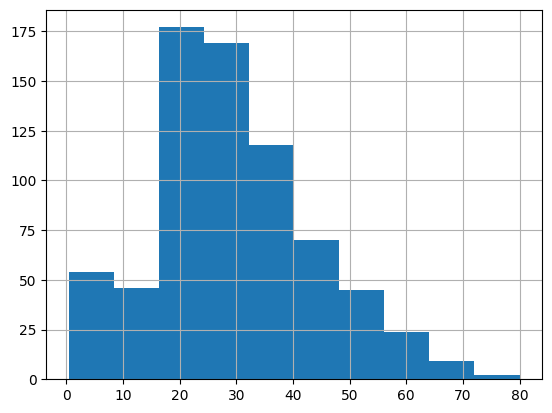

In [35]:
# 分布の確認
df_train["Age"].hist()

#### 分布を推定して外れ値を判定する方法

- 四分位範囲（IQR）
  - 四分位範囲: 75パーセンタイル - 25パーセンタイル
  - 下限値: 25パーセンタイル - 四分位範囲*1.5
  - 上限値: 75パーセンタイル - 四分位範囲*1.5

In [37]:
# 四分位範囲を利用した外れ値検出方法
quantile = df_train["Age"].quantile(q=0.75) - df_train["Age"].quantile(q=0.25)
print(f"四分位範囲:  {quantile}")
print(f"下限値:  {df_train["Age"].quantile(q=0.25) - quantile*1.5}")
print(f"上限値:  {df_train["Age"].quantile(q=0.75) + quantile*1.5}")

四分位範囲:  17.875
下限値:  -6.6875
上限値:  64.8125


#### 外れ値の補正方法

- レコードごと除外する
- 欠損値に変換する
- ヒアリングして外れ値を正しい値に変換する
- ほかのデータから推定して補正する
- 何もしない

In [38]:
# 外れ値を欠損値に変換する
# 年齢がマイナスの場合
df_train.loc[df_train["Age"] < 0, "Age"] = np.nan
df_train.loc[df_train["Age"] < 0, "Age"].head()

Series([], Name: Age, dtype: float64)

### 5.2.4 標準化・正規化

- 標準化
  - 平均値が0、標準偏差が1、になるように変換する。
  - 各値から平均値を引いて標準偏差で割る。
- 正規化
  - 最小値が0、最大値が1になるように変換する。
  - 最大値と最小値を計算して、各値から最小値を引いて、最大値と最小値の差分で割る。

In [40]:
# 標準化
value_mean = df_train["Fare"].mean()
value_std = df_train["Fare"].std(ddof=0)  # 母集団の標準偏差を利用する
# value_std = df_train["Fare"].std()  # 標本の標準偏差を利用する
print(f"mean:  {value_mean},  std:  {value_std}")

df_train["Fare_standard"] = (df_train["Fare"] - value_mean) / value_std
df_train[["Fare", "Fare_standard"]].head()

mean:  32.204207968574636,  std:  49.6655344447741


,Fare,Fare_standard
0,7.2500,-0.502445
1,71.2833,0.786845
2,7.9250,-0.488854
3,53.1000,0.420730
4,8.0500,-0.486337


In [41]:
# 標準化（scikit-learn利用）
std = StandardScaler()
std.fit(df_train[["Fare"]])
print(f"mean:  {std.mean_[0]},  std:  {np.sqrt(std.var_[0])}")

df_train["Fare_standard"] = std.transform(df_train[["Fare"]])
df_train[["Fare", "Fare_standard"]].head()

mean:  32.204207968574636,  std:  49.6655344447741


,Fare,Fare_standard
0,7.2500,-0.502445
1,71.2833,0.786845
2,7.9250,-0.488854
3,53.1000,0.420730
4,8.0500,-0.486337


In [42]:
# 正規化
value_min = df_train["Fare"].min()
value_max = df_train["Fare"].max()
print(f"min:  {value_min}  max:  {value_max}")

df_train["Fare_normalize"] = (df_train["Fare"] - value_min) / (value_max - value_min)
df_train[["Fare", "Fare_normalize"]].head()

min:  0.0  max:  512.3292


,Fare,Fare_normalize
0,7.2500,0.014151
1,71.2833,0.139136
2,7.9250,0.015469
3,53.1000,0.103644
4,8.0500,0.015713


In [43]:
# 正規化（scikit-learn利用）
mms = MinMaxScaler(feature_range=(0, 1))
mms.fit(df_train[["Fare"]])
print(f"min:  {mms.data_min_[0]}  max:  {mms.data_max_[0]}")

df_train["Fare_normalize"] = mms.transform(df_train[["Fare"]])
df_train[["Fare", "Fare_normalize"]].head()

min:  0.0  max:  512.3292


,Fare,Fare_normalize
0,7.2500,0.014151
1,71.2833,0.139136
2,7.9250,0.015469
3,53.1000,0.103644
4,8.0500,0.015713


## 5.3 特徴量生成

- 仮説ベースの特徴量生成
- 機械的な特徴量生成

### 5.3.1 単変数: 数値

- 対数変換
- 累乗、指数関数、逆数
- 離散化
- 欠損かどうかで0/1に変換

#### 対数変換

In [45]:
# 対数変換
# 1e-5=10^{-5}=0.00001
df_train["Fare_log"] = np.log(df_train["Fare"] + 1e-5)
df_train[["Fare", "Fare_log"]].head()

,Fare,Fare_log
0,7.2500,1.981003
1,71.2833,4.266662
2,7.9250,2.070024
3,53.1000,3.972177
4,8.0500,2.085673


#### 累乗、指数関数、逆数

In [46]:
# 累乗、指数関数、逆数
df_train["Fare_square"] = df_train["Fare"].apply(lambda x: x**2)
df_train["Fare_exp"] = df_train["Fare"].apply(lambda x: np.exp(x))
df_train["Fare_reciprocal"] = df_train["Fare"].apply(lambda x: 1/(x+1e-3))
df_train[["Fare", "Fare_square", "Fare_exp", "Fare_reciprocal"]].head()

,Fare,Fare_square,Fare_exp,Fare_reciprocal
0,7.2500,52.562500,1.408105e+03,0.137912
1,71.2833,5081.308859,9.077031e+30,0.014028
2,7.9250,62.805625,2.765564e+03,0.126167
3,53.1000,2819.610000,1.150898e+23,0.018832
4,8.0500,64.802500,3.133795e+03,0.124208


#### 離散化

- 年齢の離散化
  - 10代未満: 0歳以上10歳未満
  - 10代: 10歳以上20歳未満
  - 20代: 20歳以上30歳未満
  - 30代: 30歳以上40歳未満
  - 40代: 40歳以上50歳未満
  - 50代以上: 50歳以上

In [47]:
# 離散化
df_train["Age_bin"] = pd.cut(
    df_train["Age"],
    bins=[0, 10, 20, 30, 40, 50, 100],
    right=False,
    labels=["Under_10s", "10s", "20s", "30s", "40s", "50s_and_over"],
    duplicates="raise",
    include_lowest=True
)
df_train["Age_bin"] = df_train["Age_bin"].astype(str)
df_train[["Age", "Age_bin"]].head()

,Age,Age_bin
0,22.0,20s
1,38.0,30s
2,26.0,20s
3,35.0,30s
4,35.0,30s


#### 欠損かどうかで0/1に変換

In [48]:
# 欠損かどうかで0/1に変換
df_train["Age_na"] = df_train["Age"].isnull()*1
df_train[["Age", "Age_na"]].head(7)

,Age,Age_na
0,22.0,0
1,38.0,0
2,26.0,0
3,35.0,0
4,35.0,0
5,NaN,1
6,54.0,0


### 5.3.2 単変数: カテゴリ値

- One Hot Encoding
- Count Encoding
- Label Encoding
- 欠損かどうかで0/1に変換

#### One Hot Encoding

In [50]:
# one-hot-encoding
# ohe_embarked = OneHotEncoder(sparse=False)
ohe_embarked = OneHotEncoder(sparse_output=False)
ohe_embarked.fit(df_train[["Embarked"]])

tmp_embarked = pd.DataFrame(
    ohe_embarked.transform(df_train[["Embarked"]]),
    columns=["Embarked_{}".format(i) for i in ohe_embarked.categories_[0]],
)

df_train = pd.concat([df_train, tmp_embarked], axis=1)
df_train[["Embarked", "Embarked_C", "Embarked_Q", "Embarked_S", "Embarked_nan"]].head()

,Embarked,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,S,0.0,0.0,1.0,0.0
1,C,1.0,0.0,0.0,0.0
2,S,0.0,0.0,1.0,0.0
3,S,0.0,0.0,1.0,0.0
4,S,0.0,0.0,1.0,0.0


In [51]:
# one-hot-encoding（一括変換）
df_ohe = pd.get_dummies(df_train[["Embarked", "Sex"]], dummy_na=True, drop_first=False)
df_ohe.head()

,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,Sex_female,Sex_male,Sex_nan
0,False,False,True,False,False,True,False
1,True,False,False,False,True,False,False
2,False,False,True,False,True,False,False
3,False,False,True,False,True,False,False
4,False,False,True,False,False,True,False


#### Count Encoding

In [3]:
# count-encoding
ce_embarked = df_train["Embarked"].value_counts().to_dict()
print(ce_embarked)
df_train["Embarked_ce"] = df_train["Embarked"].map(ce_embarked)
df_train[["Embarked", "Embarked_ce"]].head()

{'S': 644, 'C': 168, 'Q': 77}


,Embarked,Embarked_ce
0,S,644.0
1,C,168.0
2,S,644.0
3,S,644.0
4,S,644.0


#### Label Encoding

In [4]:
# label-encoding
le_embarked = LabelEncoder()
le_embarked.fit(df_train["Embarked"])
df_train["Embarked_le"] = le_embarked.transform(df_train["Embarked"])
df_train[["Embarked", "Embarked_le"]].head()

,Embarked,Embarked_le
0,S,2
1,C,0
2,S,2
3,S,2
4,S,2


#### 欠損かどうかで0/1に変換

In [5]:
# 欠損かどうかで0/1に変換
df_train["Embarked_na"] = df_train["Embarked"].isnull()*1
df_train.loc[df_train["Embarked"].isnull(), ["Embarked", "Embarked_na"]].head()

,Embarked,Embarked_na
61,NaN,1
829,NaN,1


### 5.3.3 2変数組合せ: 数値*数値

- 数値*数値(5.3.3)
- 数値*カテゴリ値(5.3.4)
- カテゴリ値*カテゴリ値(5.3.5)

In [6]:
# 数値*数値
# 同乗している親族の人数
# SibSp: 同乗している兄弟・配偶者の人数
# Parch: 同乗している親・子供の人数
df_train["SibSp_+_Parch"] = df_train["SibSp"] + df_train["Parch"]
df_train[["SibSp", "Parch", "SibSp_+_Parch"]].head()

,SibSp,Parch,SibSp_+_Parch
0,1,0,1
1,1,0,1
2,0,0,0
3,1,0,1
4,0,0,0


### 5.3.4 2変数組合せ: 数値*カテゴリ値

In [16]:
# 数値*カテゴリ値（例1）
# 性別ごとの旅客運賃の平均値
# Sex（性別）
# Fare（旅客運賃）
df_agg = df_train.groupby("Sex")["Fare"].aggregate(["mean"]).reset_index()
df_agg.columns = ["Sex", "mean_Fare_by_Sex"]
print("集約テーブル")
display(df_agg)

df_train = pd.merge(df_train, df_agg, on="Sex", how="left")
print("結合後のテーブル")
display(df_train[["Sex", "Fare", "mean_Fare_by_Sex"]].head())

集約テーブル


,Sex,mean_Fare_by_Sex
0,female,44.479818
1,male,25.523893


結合後のテーブル


,Sex,Fare,mean_Fare_by_Sex
0,male,7.2500,25.523893
1,female,71.2833,44.479818
2,female,7.9250,44.479818
3,female,53.1000,44.479818
4,male,8.0500,25.523893


In [17]:
# 数値*カテゴリ値（例2）
# 性別ごとの旅客運賃の平均値
# Sex（性別）
# Fare（旅客運賃）
df_train["mean_Fare_by_Sex"] = df_train.groupby("Sex")["Fare"].transform("mean")
df_train[["Sex", "Fare", "mean_Fare_by_Sex"]].head()

,Sex,Fare,mean_Fare_by_Sex
0,male,7.2500,25.523893
1,female,71.2833,44.479818
2,female,7.9250,44.479818
3,female,53.1000,44.479818
4,male,8.0500,25.523893


### 5.3.5 2変数組合せ: カテゴリ値*カテゴリ値

- カテゴリ値*カテゴリ値: 出現回数
- カテゴリ値*カテゴリ値: 出現割合
- カテゴリ値*カテゴリ値: 条件を用いた変換

#### カテゴリ値*カテゴリ値: 出現回数

In [20]:
# カテゴリ値*カテゴリ値: 出現回数（例1）
# 性別べつの各乗船港の乗船者数
df_tbl = pd.crosstab(df_train["Sex"], df_train["Embarked"])
print("集約テーブル（クロス集計）")
display(df_tbl)

df_tbl = df_tbl.reset_index()
df_tbl = pd.melt(df_tbl, id_vars="Sex", value_name="count_Sex_x_Embarked")
print("集約テーブル（縦持ち変換後）")
display(df_tbl)

df_train = pd.merge(df_train, df_tbl, on=["Sex", "Embarked"], how="left")
print("結合後テーブル")
df_train[["Sex", "Embarked", "count_Sex_x_Embarked"]].head()

集約テーブル（クロス集計）


Embarked,C,Q,S
Sex,,,
female,73,36,203
male,95,41,441


集約テーブル（縦持ち変換後）


,Sex,Embarked,count_Sex_x_Embarked
0,female,C,73
1,male,C,95
2,female,Q,36
3,male,Q,41
4,female,S,203
5,male,S,441


結合後テーブル


,Sex,Embarked,count_Sex_x_Embarked
0,male,S,441.0
1,female,C,73.0
2,female,S,203.0
3,female,S,203.0
4,male,S,441.0


In [21]:
# カテゴリ値*カテゴリ値: 出現回数（例2）
# 性別べつの各乗船港の乗船者数
df_train["count_Sex_x_Embarked"] = df_train.groupby(["Sex", "Embarked"])["PassengerId"].transform("count")
df_train[["Sex", "Embarked", "count_Sex_x_Embarked"]].head()

,Sex,Embarked,count_Sex_x_Embarked
0,male,S,441.0
1,female,C,73.0
2,female,S,203.0
3,female,S,203.0
4,male,S,441.0


#### カテゴリ値*カテゴリ値: 出現割合

In [24]:
# カテゴリ値*カテゴリ値: 出現割合（例1）
# 性別べつの各乗船港の乗船者割合
df_tbl = pd.crosstab(df_train["Sex"], df_train["Embarked"], normalize="index")
print("集約テーブル")
display(df_tbl)

df_tbl = df_tbl.reset_index()
df_tbl = pd.melt(df_tbl, id_vars="Sex", value_name="rate_Sex_x_Embarked")
print("集約テーブル（縦持ち変換後）")
display(df_tbl)

df_train = pd.merge(df_train, df_tbl, on=["Sex", "Embarked"], how="left")
print("結合後のテーブル")
df_train[["Sex", "Embarked", "rate_Sex_x_Embarked"]].head()

集約テーブル


Embarked,C,Q,S
Sex,,,
female,0.233974,0.115385,0.650641
male,0.164645,0.071057,0.764298


集約テーブル（縦持ち変換後）


,Sex,Embarked,rate_Sex_x_Embarked
0,female,C,0.233974
1,male,C,0.164645
2,female,Q,0.115385
3,male,Q,0.071057
4,female,S,0.650641
5,male,S,0.764298


結合後のテーブル


,Sex,Embarked,rate_Sex_x_Embarked
0,male,S,0.764298
1,female,C,0.233974
2,female,S,0.650641
3,female,S,0.650641
4,male,S,0.764298


#### カテゴリ値*カテゴリ値: 条件を用いた変換

In [25]:
# カテゴリ値*カテゴリ値: 条件を用いた変換
# Sex:male & Embarked:S = 1
df_train["Sex=male_&_Embarked=S"] = np.where((df_train["Sex"]=="male") & (df_train["Embarked"]=="S"), 1, 0)
df_train[["Sex", "Embarked", "Sex=male_&_Embarked=S"]].head()

,Sex,Embarked,Sex=male_&_Embarked=S
0,male,S,1
1,female,C,0
2,female,S,0
3,female,S,0
4,male,S,1


### 5.3.6 時系列データ

- ラグ特徴量
- ウィンドウ特徴量
- 累積特徴量

#### ラグ特徴量

In [26]:
# ラグ特徴量（1行シフト）
df1 = pd.DataFrame({
    "date": pd.date_range("2021-01-01", "2021-01-10"),
    "weather": ["晴れ", "晴れ", "雨", "くもり", "くもり", "晴れ", "雨", "晴れ", "晴れ", "晴れ"],
})
df1["weather_shift1"] = df1["weather"].shift(1)
df1

,date,weather,weather_shift1
0,2021-01-01,晴れ,None
1,2021-01-02,晴れ,晴れ
2,2021-01-03,雨,晴れ
3,2021-01-04,くもり,雨
4,2021-01-05,くもり,くもり
5,2021-01-06,晴れ,くもり
6,2021-01-07,雨,晴れ
7,2021-01-08,晴れ,雨
8,2021-01-09,晴れ,晴れ
9,2021-01-10,晴れ,晴れ


In [27]:
# ラグ特徴量（1行シフト）: シフトのよって生じた欠損値を補間
# 欠損値を前埋めする場合
df1["weather_shift1"] = df1["weather_shift1"].interpolate(method="bfill")
df1

,date,weather,weather_shift1
0,2021-01-01,晴れ,晴れ
1,2021-01-02,晴れ,晴れ
2,2021-01-03,雨,晴れ
3,2021-01-04,くもり,雨
4,2021-01-05,くもり,くもり
5,2021-01-06,晴れ,くもり
6,2021-01-07,雨,晴れ
7,2021-01-08,晴れ,雨
8,2021-01-09,晴れ,晴れ
9,2021-01-10,晴れ,晴れ


In [28]:
# ラグ特徴量（IDごとにシフト）
df2 = pd.DataFrame(
    {
        "id": ["A"]*3 + ["B"]*2 + ["C"]*4,
        "date": [
            "2021-04-02",
            "2021-04-10",
            "2021-04-25",
            "2021-04-18",
            "2021-04-19",
            "2021-04-01",
            "2021-04-04",
            "2021-04-09",
            "2021-04-12",
        ],
        "money": [1000, 2000, 900, 4000, 1800, 900, 1200, 1100, 2900],
    }
)
df2["date"] = pd.to_datetime(df2["date"], format="%Y-%m-%d")
df2["money_shift1"] = df2.groupby("id")["money"].shift(1)
df2

,id,date,money,money_shift1
0,A,2021-04-02,1000,NaN
1,A,2021-04-10,2000,1000.0
2,A,2021-04-25,900,2000.0
3,B,2021-04-18,4000,NaN
4,B,2021-04-19,1800,4000.0
5,C,2021-04-01,900,NaN
6,C,2021-04-04,1200,900.0
7,C,2021-04-09,1100,1200.0
8,C,2021-04-12,2900,1100.0


In [29]:
# ラグ特徴量（経過日数）
df2["date_shift1"] = df2.groupby("id")["date"].shift(1)
df2["days_elapsed"] = df2["date"] - df2["date_shift1"]
df2["days_elapsed"] = df2["days_elapsed"].dt.days
df2

,id,date,money,money_shift1,date_shift1,days_elapsed
0,A,2021-04-02,1000,NaN,NaT,NaN
1,A,2021-04-10,2000,1000.0,2021-04-02,8.0
2,A,2021-04-25,900,2000.0,2021-04-10,15.0
3,B,2021-04-18,4000,NaN,NaT,NaN
4,B,2021-04-19,1800,4000.0,2021-04-18,1.0
5,C,2021-04-01,900,NaN,NaT,NaN
6,C,2021-04-04,1200,900.0,2021-04-01,3.0
7,C,2021-04-09,1100,1200.0,2021-04-04,5.0
8,C,2021-04-12,2900,1100.0,2021-04-09,3.0


#### ウィンドウ特徴量

In [3]:
# ウィンドウ特徴量
df3 = pd.DataFrame(
    {
        "date": pd.date_range("2021-01-01", "2021-01-10"),
        "temperature": [8, 10, 12, 11, 9, 10, 12, 7, 9, 10],
    }
)
df3["temperature_window3"] = df3["temperature"].rolling(window=3).mean()
df3

,date,temperature,temperature_window3
0,2021-01-01,8,NaN
1,2021-01-02,10,NaN
2,2021-01-03,12,10.000000
3,2021-01-04,11,11.000000
4,2021-01-05,9,10.666667
5,2021-01-06,10,10.000000
6,2021-01-07,12,10.333333
7,2021-01-08,7,9.666667
8,2021-01-09,9,9.333333
9,2021-01-10,10,8.666667


In [7]:
# ウィンドウ特徴量（IDごと）
df4 = pd.DataFrame(
    {
        "id": ["A"]*3 + ["B"]*2 + ["C"]*4,
        "date": [
            "2021-04-02",
            "2021-04-10",
            "2021-04-25",
            "2021-04-18",
            "2021-04-19",
            "2021-04-01",
            "2021-04-04",
            "2021-04-09",
            "2021-04-12",
        ],
        "money": [1000, 2000, 900, 4000, 1800, 900, 1200, 1100, 2900],
    }
)
df4["date"] = pd.to_datetime(df4["date"], format="%Y-%m-%d")
# df4["money_shift1"] = df4.groupby("id")["money"].apply(lambda x: x.rolling(window=2).mean())
df4["money_shift1"] = df4.groupby("id")["money"].transform(lambda x: x.rolling(window=2).mean())
df4

,id,date,money,money_shift1
0,A,2021-04-02,1000,NaN
1,A,2021-04-10,2000,1500.0
2,A,2021-04-25,900,1450.0
3,B,2021-04-18,4000,NaN
4,B,2021-04-19,1800,2900.0
5,C,2021-04-01,900,NaN
6,C,2021-04-04,1200,1050.0
7,C,2021-04-09,1100,1150.0
8,C,2021-04-12,2900,2000.0


#### 累積特徴量

In [9]:
# 累積特徴量
df5 = pd.DataFrame(
    {
        "date": pd.date_range("2021-01-01", "2021-01-10"),
        "flag_rain": [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    }
)
df5["flag_rain_cumsum"] = df5["flag_rain"].cumsum()
df5

,date,flag_rain,flag_rain_cumsum
0,2021-01-01,0,0
1,2021-01-02,0,0
2,2021-01-03,1,1
3,2021-01-04,0,1
4,2021-01-05,0,1
5,2021-01-06,0,1
6,2021-01-07,1,2
7,2021-01-08,0,2
8,2021-01-09,0,2
9,2021-01-10,0,2


In [11]:
# 累積特徴量（IDごと）
df6 = pd.DataFrame(
    {
        "id": ["A"] * 3 + ["B"] * 2 + ["C"] * 4,
        "date": [
            "2021-04-02",
            "2021-04-10",
            "2021-04-25",
            "2021-04-18",
            "2021-04-19",
            "2021-04-01",
            "2021-04-04",
            "2021-04-09",
            "2021-04-12",
        ],
        "money": [1000, 2000, 900, 4000, 1800, 900, 1200, 1100, 2900],
    }
)
df6["date"] = pd.to_datetime(df6["date"], format="%Y-%m-%d")
df6["money_cumsum"] = df6.groupby("id")["money"].cumsum()
df6

,id,date,money,money_cumsum
0,A,2021-04-02,1000,1000
1,A,2021-04-10,2000,3000
2,A,2021-04-25,900,3900
3,B,2021-04-18,4000,4000
4,B,2021-04-19,1800,5800
5,C,2021-04-01,900,900
6,C,2021-04-04,1200,2100
7,C,2021-04-09,1100,3200
8,C,2021-04-12,2900,6100


### 5.3.7 テキストデータ

- 単語の出現回数（BoW: Bag of Words）
- TF-IDF
- word2vec
- BERT

## 5.4 データセット作成

### 5.4.1 特徴量選択の方法

- フィルター法（filter method）
- ラッパー法（wrapper method）
- 組み込み法（embedded method）

### 5.4.2 ラッパー法の進め方

- 特徴量の追加作成
- 追加した特徴量を加えたデータセットを作成
- モデル学習して精度評価
- 精度が上がれば採用。下がれば不採用。